In [1]:
# Dependencies
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from modules.dataset import load_words
from modules.network import get_edges, map_words, get_degree
from modules.words import load_data

# Set up default colors
colors=[*mc.TABLEAU_COLORS.values()]

%matplotlib inline

[nltk_data] Downloading package wordnet to /home/domenico/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/domenico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset

## Dataset creation

In [5]:
# Load words dataset table
words = load_words('data/words_greta.csv')
words.rename(columns={'id':'tweet'}, inplace=True)
words.head()

,tweet,index,text,pos,conf
0,1006327664976617472,1,new,A,0.9980
1,1006327664976617472,2,paper,N,0.9881
2,1006327664976617472,5,show,V,0.9870
3,1006327664976617472,7,temperature,N,0.9922
4,1006327664976617472,8,goal,N,0.9671


In [6]:
# Retrieve dictionaries mapping lemma tuples to numeric value
w2i, i2w = map_words(words)

In [7]:
# Map lemmas to node numbers
words['node'] = words.apply(lambda w: w2i[(w.text, w.pos)], axis=1)
words.head()

,tweet,index,text,pos,conf,node
0,1006327664976617472,1,new,A,0.9980,4212
1,1006327664976617472,2,paper,N,0.9881,4498
2,1006327664976617472,5,show,V,0.9870,5839
3,1006327664976617472,7,temperature,N,0.9922,6473
4,1006327664976617472,8,goal,N,0.9671,2811


In [8]:
# Load tweets dataset table
tweets = load_data('greta')
tweets.head()

,created_at,id,text,retweet_count,favorite_count,original_retweet_count,original_favorite
0,2018-06-12 00:09:46+00:00,1006327664976617472,Our new paper in @NatureClimate shows that tem...,0,0,32.0,50.0
1,2018-06-12 00:09:40+00:00,1006327640226189318,“The transition to accessible and clean energy...,0,0,128.0,174.0
2,2018-06-12 00:09:26+00:00,1006327582235688961,"The federal government won't lead on climate, ...",0,0,1349.0,2434.0
3,2018-06-12 00:09:26+00:00,1006327581556084736,Extreme Hurricane Rainfall Expected to Increas...,1,0,NaN,NaN
4,2018-06-12 00:09:14+00:00,1006327528397697025,"""UN Women: Women To Be Heard When Tackling Cli...",2,1,NaN,NaN


## Dataset statistics

### Number of tweets

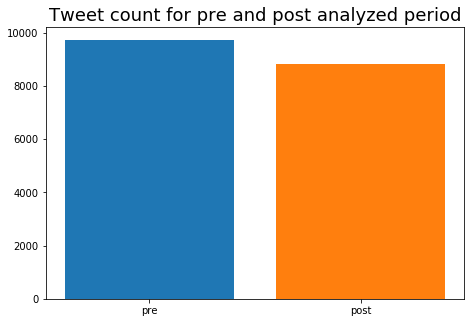

In [6]:
# Define words from tweets of pre and the ones from tweets of post
pre = 2018
post = 2019
tweets_pre = tweets.id[tweets.created_at.dt.year == pre].values
tweets_post = tweets.id[tweets.created_at.dt.year == post].values

# Show tweets distribution
fig, ax = plt.subplots(figsize=(7.5, 5))
_ = ax.set_title('Tweet count for pre and post analyzed period', fontsize=18)
_ = ax.bar(['pre'], [len(tweets_pre)])
_ = ax.bar(['post'], [len(tweets_post)])
#_ = plt.savefig('images/analysis/tweet_counts.png')
_ = plt.show()

### Words count

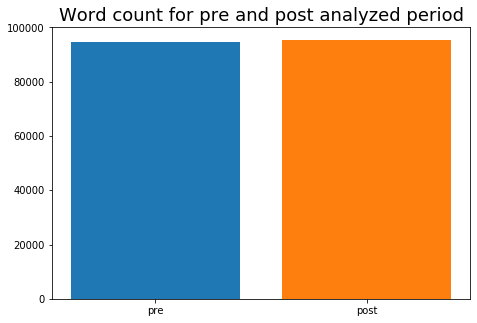

In [7]:
# Show word counts in tweets of pre and post respectively
fig, ax = plt.subplots(figsize=(7.5, 5))
_ = ax.set_title('Word count for pre and post analyzed period', fontsize=18)
_ = ax.bar(['pre'], sum(words.tweet.isin(tweets_pre)))
_ = ax.bar(['post'], sum(words.tweet.isin(tweets_post)))
#_ = plt.savefig('images/analysis/words_counts.png')
_ = plt.show()

### Unique words count

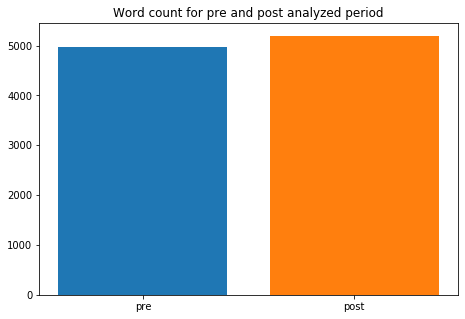

In [8]:
# Show unique word counts in tweets of pre and post respectively

unique_words_pre = words.text[words.tweet.isin(tweets_pre)].unique()
unique_words_post = words.text[words.tweet.isin(tweets_post)].unique()

fig, ax = plt.subplots(figsize=(7.5, 5))
_ = ax.set_title('Word count for pre and post analyzed period')
_ = ax.bar(['pre'], unique_words_pre.shape[0])
_ = ax.bar(['post'], unique_words_post.shape[0])
#_ = plt.savefig('images/analysis/nodes_counts.png')
_ = plt.show()

### Tweets lengths distributions

Histogram shows the distribution of tweet lengths in either pre's and post'2 network. The difference in the two distributions is due to the fact that in november pre the allowed tweet lengths in term of characters has been duplicated by Twitter itself.

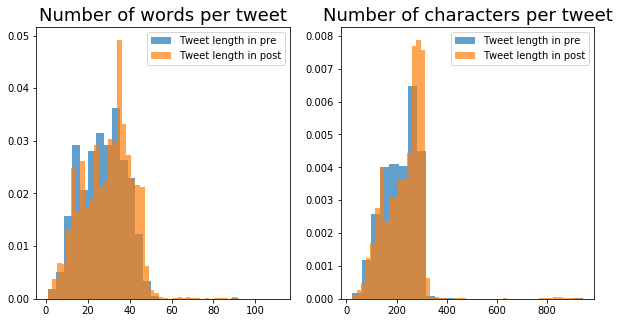

In [9]:
# Compute length of each tweet, for either words and characters
tweets_ = tweets.loc[:, ['id']]
tweets_['len_words'] = tweets.apply(lambda t: len(t.text.split(' ')), axis=1)
tweets_['len_chars'] = tweets.apply(lambda t: len(t.text), axis=1)

# Get pre and post tweets
tweets_pre_ = tweets_[tweets_['id'].isin(tweets_pre)]
tweets_post_ = tweets_[tweets_['id'].isin(tweets_post)]

# Show distribution of words number per tweet in pre and post
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Word lengths
_ = axs[0].set_title('Number of words per tweet',fontsize=18)
_ = axs[0].hist(tweets_pre_['len_words'], bins=25, density=True, alpha=.7)
_ = axs[0].hist(tweets_post_['len_words'], bins=50, density=True, alpha=.7)
_ = axs[0].legend(['Tweet length in pre', 'Tweet length in post'])
# Charactes lengths
_ = axs[1].set_title('Number of characters per tweet', fontsize=18)
_ = axs[1].hist(tweets_pre_['len_chars'], bins=25, density=True, alpha=.7)
_ = axs[1].hist(tweets_post_['len_chars'], bins=50, density=True, alpha=.7)
_ = axs[1].legend(['Tweet length in pre', 'Tweet length in post'])
# Make plot
#_ = plt.savefig('images/analysis/tweet_len_distr.png')
_ = plt.show()

### Hashtag Distribution conditioned to the presence of #climatechange

# Network creation

## Edges creation

In [10]:
# Define years under examination
years = [pre, post]

In [11]:
# Define edges for pre and post (as Pandas DataFrames)
edges = dict()
# Define edges for each network
for y in years:
    # Get id of tweets for current year
    tweet_ids = tweets.id[tweets.created_at.dt.year == y]
    # Compute edges for current year
    edges[y] = get_edges(words[words.tweet.isin(tweet_ids)])

                 tweet  index_x text_x pos_x  conf_x  node_x  index_y  \
0  1006327664976617472        1    new     A   0.998    4212        1   
1  1006327664976617472        1    new     A   0.998    4212        2   
2  1006327664976617472        1    new     A   0.998    4212        5   
3  1006327664976617472        1    new     A   0.998    4212        7   
4  1006327664976617472        1    new     A   0.998    4212        8   

        text_y pos_y  conf_y  node_y  
0          new     A  0.9980    4212  
1        paper     N  0.9881    4498  
2         show     V  0.9870    5839  
3  temperature     N  0.9922    6473  
4         goal     N  0.9671    2811  
                 tweet  index_x text_x pos_x  conf_x  node_x  index_y  text_y  \
0  1101772852863340544        1  voice     N   0.997    7049        1   voice   
1  1101772852863340544        1  voice     N   0.997    7049        3    loud   
2  1101772852863340544        1  voice     N   0.997    7049        7      we   
3  

In [ ]:
# Save vocabularies to disk
#np.save('data/edges_w2i.npy', w2i)  # Save tuple to index vocabulary
#np.save('data/edges_i2w.npy', i2w)  # Save index to tuple vocabulary

In [ ]:
# Save edges to disk
edges_ = [*years]
# Loop through each edges table
for i, y in enumerate(years):
    # Add year column
    edges_[i] = edges[y].copy()
    edges_[i]['year'] = y
    
# Concatenate DataFrames
edges_ = pd.concat(edges_, axis=0)
# Save dataframe to disk
#edges_.to_csv('data/database/edges.csv', index=False)

In [12]:
print('Edges for pre\'s network')
edges[pre].head()

Edges for pre's network


,node_x,node_y,weight
0,0,917,1
1,0,1336,1
2,0,2938,1
3,0,3584,1
4,0,3629,1


In [13]:
print('Edges for post\'s network')
edges[post].head()

Edges for post's network


,node_x,node_y,weight
0,2,872,1
1,2,1058,1
2,2,1566,1
3,2,2044,1
4,2,2098,1


## Adjacency matrices

Compute upper triangular adjacency matrices for either pre's and post's networks. 

Note: adjacency matrices are saved by default to avoid recomputing.

In [14]:
# Define networks container
network = dict()
# Create newtorks
for y in years:
    network[y] = nx.from_pandas_edgelist(edges[y], source='node_x', target='node_y', 
                                         edge_attr=True, create_using=nx.Graph)

In [15]:
# Get numpy adjacency matrices
adj_matrix = dict()
for y in years:
    adj_matrix[y] = nx.to_numpy_matrix(network[y])

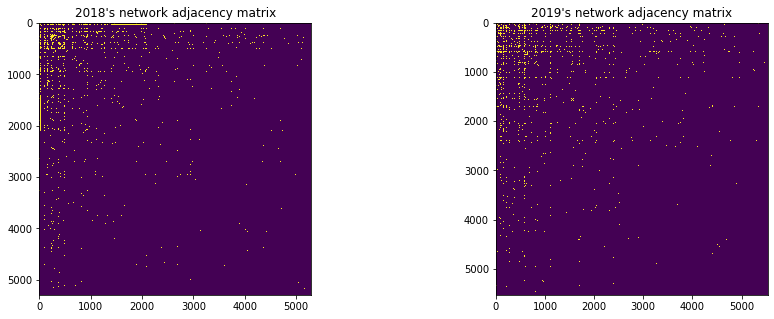

In [16]:
# Show adjacency matrices
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Print adjacency matrix for each network
for i, y in enumerate(years):
    _ = axs[i].set_title('{:d}\'s network adjacency matrix'.format(y))
    _ = axs[i].imshow(np.minimum(adj_matrix[y], np.ones(adj_matrix[y].shape)))
_ = plt.show()

In [17]:
adj_matrix[pre].shape

(5292, 5292)

## Summary statistics

Compute mean, density, and other summary statistics for both pre's and post's networks

In [18]:
# Initialize summary statistics
mean = {}
density = {}
std = {}

# Compute mean and density
for y in years:
    x = adj_matrix[y]  # Get adjacency matrix for current network
    n = x.shape[0]  # Get dimension of the adjacency matrix
    mean[y] = x.sum() / n**2
    std[y] = ( ((x - mean[y])**2).sum() / (n**2 - 1) )**.5
    density[y] = np.minimum(x, np.ones((n, n))).sum() / n**2
    
# Print out results
for y in years:
    print('{:d}\'s network has mean={:.04f}, standard deviation={:.04f} and density={:.04f}'.format(y, mean[y], std[y], density[y]))

2018's network has mean=0.0375, standard deviation=17.7951 and density=0.0115
2019's network has mean=0.0385, standard deviation=21.4409 and density=0.0117


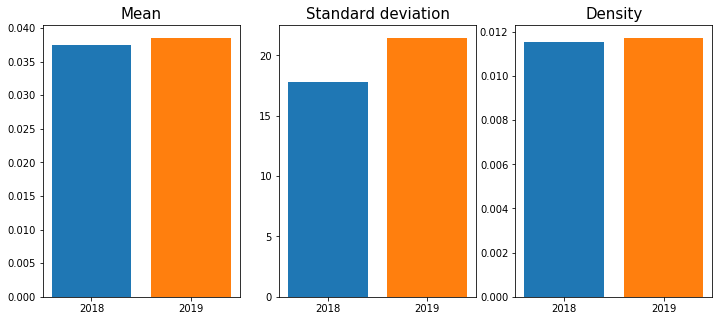

In [19]:
# Show summary statistics graphically
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
_ = axs[0].set_title('Mean',fontsize=15)
_ = axs[1].set_title('Standard deviation',fontsize=15)
_ = axs[2].set_title('Density',fontsize=15)
# Print scores for either pre and post
for y in years:
    _ = axs[0].bar(str(y), mean[y])
    _ = axs[1].bar(str(y), std[y])
    _ = axs[2].bar(str(y), density[y])
# Make plot
#_ = plt.savefig('images/analysis/net_stats.png')
_ = plt.show()

## Degrees analysis

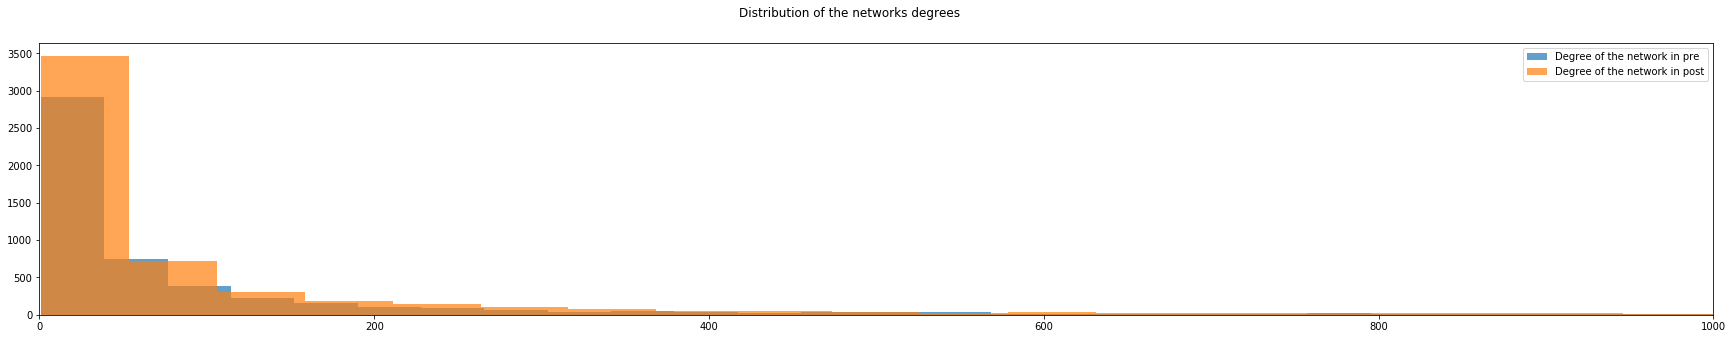

In [24]:
# Compare degrees graphically
fig, ax = plt.subplots(figsize=(30, 5))
_ = fig.suptitle('Distribution of the networks degrees')
_ = ax.hist(get_degree(network[pre]), bins=2000, alpha=0.7)
_ = ax.hist(get_degree(network[post]), bins=2000, alpha=0.7)
_ = ax.set_xlim(0, 1000)
_ = ax.legend(['Degree of the network in pre',
               'Degree of the network in post'])
#_ = plt.savefig('images/analysis/degree_hist.png')
_ = plt.show()

In [25]:
# Define function for computing degree analysis (compute pdf, cdf, ...)
def make_degree_analysis(network):
    """
    Input:
    - degrees Pandas Series node (index) maps to its degree (value)
    Output:
    - degree: list of degrees
    - counts: list containing count for each degree 
    - pdf (probability distribution function): list
    - cdf (cumulative distribution function): list
    """
    # Get number of times a degree appeared in the network
    degree = get_degree(network)
    degree, count = np.unique(degree.values, return_counts=True)
    pdf = count / np.sum(count)  # Compute pdf
    cdf = list(1 - np.cumsum(pdf))[:-1] + [0]  # Compute cdf
    # Return computed statistics
    return degree, count, pdf, cdf

In [26]:
# Define function for plotting degree analysis
def plot_degree_analysis(network):
    
    # Initialize plot
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    _ = axs[0].set_title('Probability Distribution',fontsize=14)
    _ = axs[1].set_title('Log-log Probability Distribution',fontsize=14)
    _ = axs[2].set_title('Log-log Cumulative Distribution',fontsize=14)
    
    # Create plot fore each network
    for i, y in enumerate(network.keys()):
        # Compute degree statistics
        k, count, pdf, cdf = make_degree_analysis(network[y])
        # Make plots
        _ = axs[0].plot(k, pdf, 'o', alpha=.7)
        _ = axs[1].loglog(k, pdf, 'o', alpha=.7)
        _ = axs[2].loglog(k, cdf, 'o', alpha=.7)

    # Show plots
    _ = [axs[i].legend([str(y) for y in network.keys()], loc='upper right') for i in range(3)]
    #_ = plt.savefig('images/analysis/degree_distr.png')
    _ = plt.show()

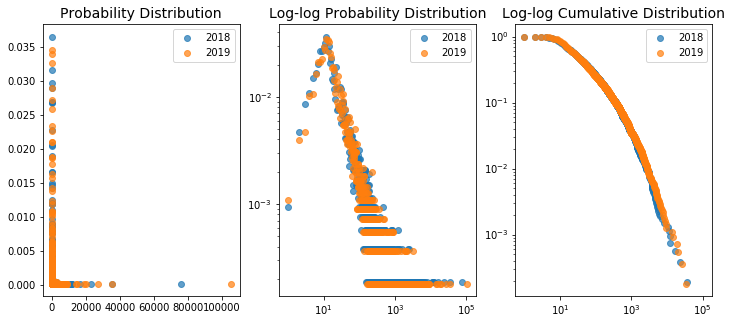

In [27]:
# Plot pdf, cdf, log-log, ... of each network
plot_degree_analysis(network)

# Scale-free property

## Power law estimation

In [35]:
# Estimate power law parameters for each network

# Initialize power law parameters
power_law = {
    pre: {'k_sat': 9},
    post: {'k_sat': 9}
}

# Define parameters for each network
for i, y in enumerate(years):
    # Get the unique values of degree and their counts
    degree = get_degree(network[y])
    k, count = np.unique(degree, return_counts=True)
    k_sat = power_law[y]['k_sat']
    # Define minumum and maximum k (degree)
    power_law[y]['k_min'] = k_min = np.min(k)
    power_law[y]['k_max'] = k_max = np.max(k)
    # Estimate parameters
    n = degree[k_sat:].shape[0]
    gamma = 1 + n / np.sum(np.log(degree[k_sat:] / k_sat))
    c = (gamma - 1) * k_sat ** (gamma - 1)
    # Compute cutoff
    cutoff = k_sat * n ** (1 / (gamma - 1))
    # Store parameters
    power_law[y]['gamma'] = gamma
    power_law[y]['c'] = c
    power_law[y]['cutoff'] = cutoff

In [36]:
# Pront out coefficients
for y in power_law.keys():
    # Retrieve parameters
    gamma, c, cutoff = power_law[y]['gamma'], power_law[y]['c'], power_law[y]['cutoff']
    k_min, k_max = power_law[y]['k_min'], power_law[y]['k_max']
    # Print results
    out = 'Power law estimated parameters for {:d}\'s network:\n'
    out += '  gamma={:.03f}, c={:.03f}, cutoff={:.03f}, min.degree={:d}, max.degree={:d}'
    print(out.format(y, gamma, c, cutoff, k_min, k_max))

Power law estimated parameters for 2018's network:
  gamma=1.649, c=2.704, cutoff=4874496.978, min.degree=1, max.degree=75648
Power law estimated parameters for 2019's network:
  gamma=1.643, c=2.642, cutoff=5933276.937, min.degree=1, max.degree=105004


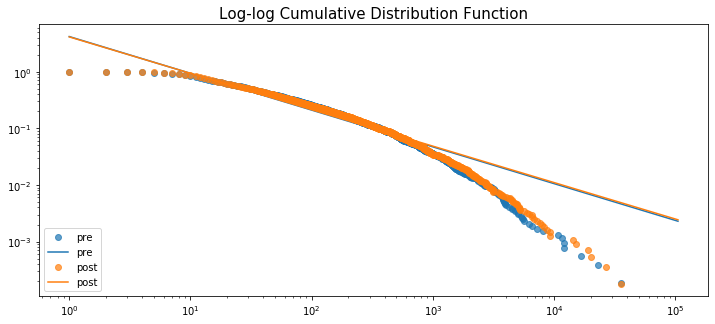

In [37]:
# Define regression lines values for either pre and post distributions

# Define regression lines container
regression_line = {}
# Define maximum degree, for both years together
k_max = np.max([power_law[y]['k_max'] for y in power_law.keys()])
# Compute regression lines
for y in power_law.keys():
    # Retrieve parameters gamma and c
    gamma = power_law[y]['gamma']
    c = power_law[y]['c']
    # Compute regression line
    regression_line[y] = c * np.arange(1, k_max) ** (1 - gamma) / (gamma - 1)

# Plot results
fig, ax = plt.subplots(figsize=(12, 5))
_ = ax.set_title('Log-log Cumulative Distribution Function',fontsize=15)
# Print  every network
for i, y in enumerate(power_law.keys()):
    # Retrieve degree analysis values
    k, count, pdf, cdf = make_degree_analysis(network[y])
    # Print dots
    _ = ax.loglog(k, cdf, 'o', alpha=.7, color=colors[i])
    # Print regression line
    _ = ax.loglog(np.arange(1, k_max), regression_line[y], color=colors[i])
# Make plot
_ = ax.legend(['pre']*2 + ['post']*2, loc='lower left')
#_ = plt.savefig('images/analysis/power_law.png')
_ = plt.show()

# Small-world property

## Connected components

In [ ]:
'''# Extract cardinality of connected components and diameter of the giant component for both nets

# Initialize components container
connected_components = {}

# Compute giant component for every network
for i, y in enumerate(network.keys()):
    # Compute connected component
    cc = sorted(nx.connected_components(network[y]), key=len, reverse=True)        
    # Compute diameter of the giant component
    d = nx.diameter(network[y].subgraph(cc[0]))
    # Store the tuple (giant component, cardinality, diameter)
    connected_components[y] = []
    connected_components[y].append({
        'component': cc[0],
        'size': len(cc[0]),
        'diameter': d
    })
    
    print({
        'component': cc[0],
        'size': len(cc[0]),
        'diameter': d
    })
    # Store each component
    for component in cc[1:]:
        # Add component, without diameter
        connected_components[y].append({
            'component': component,
            'size': len(component)
        })
        print({
            'component': component,
            'size': len(component)
        })
        
        

# Save connected components to disk
#np.save('data/connected_components.npy', connected_components)'''

In [ ]:
# Load connected components from file
connected_components = np.load('data/connected_components.npy', allow_pickle=True).item()

# Show connected components info for each year
for y in years:
    # Retrieve connected component
    cc = connected_components[y]
    # Show giant component info
    print('Network {:d}'.format(y))
    print('Giant component has cardinality={:d} and diameter={:d}'.format(cc[0]['size'], cc[0]['diameter']))
    # Store each component
    for j, component in enumerate(cc):
          if j == 0: continue
          # Show other components
          print('Connected component nr {:d} has cardinality={:d}'.format(j + 1, component['size']))
    print()

## Clustering coefficient

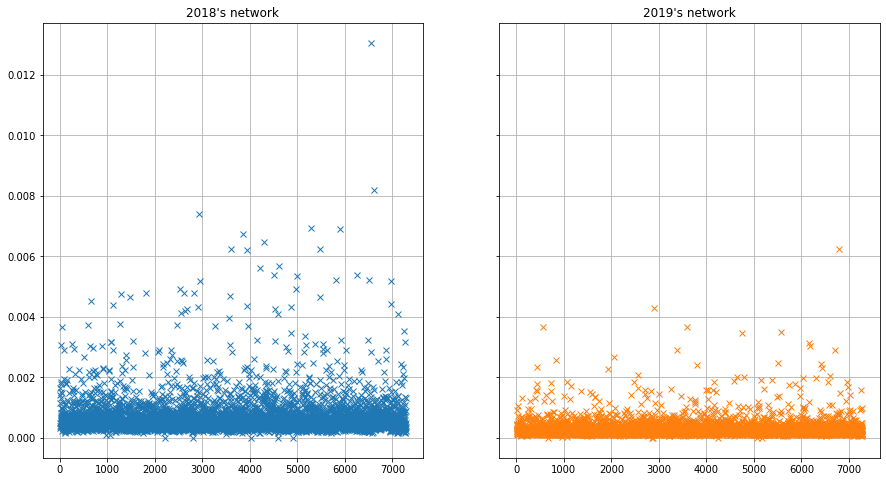

In [44]:
# Compute and show chlustering coefficients

# Compute clustering coefficients
clust_coef = {y: pd.Series(nx.clustering(network[y], weight='weight')) for y in years}

# Make plot
fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
# Loop through each network
for i, y in enumerate(years):
    cc = clust_coef[y]
    _ = axs[i].set_title('{:d}\'s network'.format(y))
    _ = axs[i].plot(cc.index.values, cc.values, 'x', mec=colors[i])
    _ = axs[i].grid()
# Show plot
#_ = plt.savefig('images/analysis/clust_coeff.png')
_ = plt.show()

In [ ]:
giant = {y: connected_components[y][0]['component'] for y in years}

# Compute the average shortest path length for both nets
L = {y: nx.average_shortest_path_length(network[y].subgraph(giant[y]), weight='counts', method='floyd-warshall-numpy') for y in years}

In [ ]:
for y in years:
    print('Network {:d}'.format(y))
    N = len(network[y].nodes)
    print('log N: {:.4f}'.format( np.log(N) ))
    print('log log N: {:.4f}'.format( np.log( np.log(N) ) ))
    print('Average shortest path length: {:.4f}'.format(L[y]))
    print('Average clustering coefficient: {:.4f}'.format(np.mean(clust_coef[y])))
    print()

# Ranking

## Ranking of words

### Ranking by degree

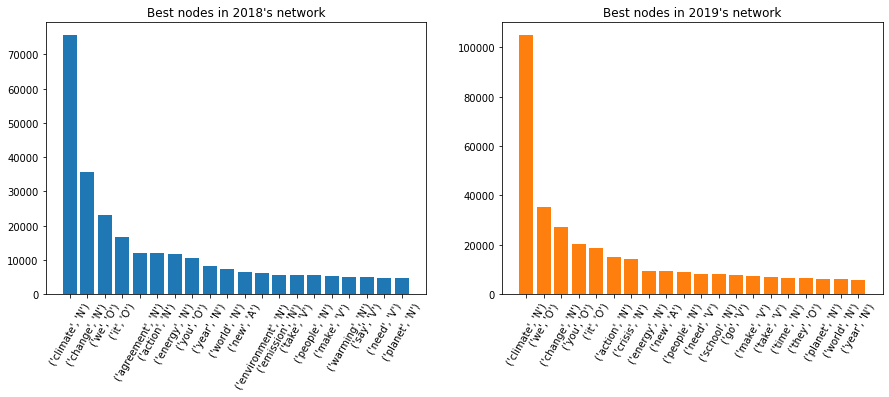

In [39]:
# Define subset (firs n-th)
best = 20

# Make plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plot each network
for i, y in enumerate(years):
    degree = get_degree(network[y]).sort_values(ascending=False)
    _ = axs[i].set_title('Best nodes in {:d}\'s network'.format(y))
    _ = axs[i].bar(degree.index[:best].map(lambda x: str(i2w[x])), degree.values[:best], color=colors[i])
    _ = axs[i].tick_params(axis='x', labelrotation=60)
# Show plot
#_ = plt.savefig('images/analysis/words_rank_degree.png', bbox_inches='tight')
_ = plt.show()

### Ranking by betweenness

In [40]:
'''# Compute betweenness centrality measure for nodes (on giant components)

betweenness = {}

for y in years:
    # Define giant component subgraph
    # giant_component = connected_components[y][0]['component']
    # subgraph = nx.induced_subgraph(network[y], giant_component)
    # Compute betweenness
    betweenness[y] = nx.betweenness_centrality(network[y], weight='weight')
    
# Save betweenness as numpy array
np.save('data/betweenness_greta.npy', betweenness)'''

In [41]:
# Load betweenness
betweenness = np.load('data/betweenness_greta.npy', allow_pickle=True).item()

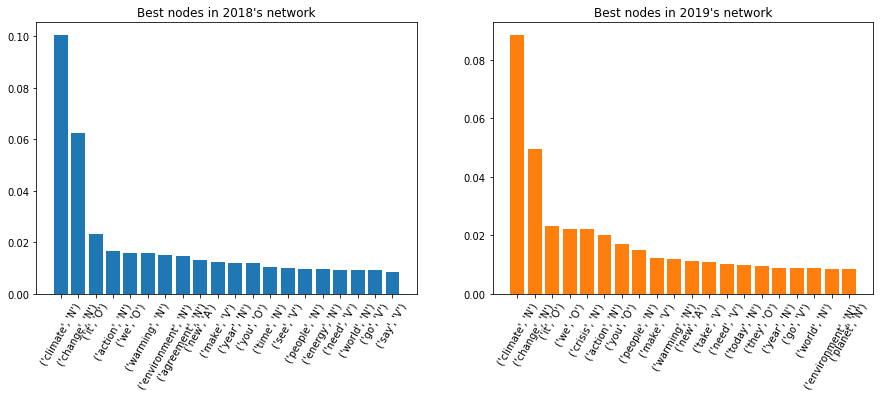

In [43]:
# Define subset (firs n-th)
best = 20

# Make plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i, y in enumerate(years):
    btw = pd.Series(betweenness[y]).sort_values(ascending=False)
    _ = axs[i].set_title('Best nodes in {:d}\'s network'.format(y))
    _ = axs[i].bar(btw.index[:best].map(lambda x: str(i2w[x])), btw.values[:best], color=colors[i])
    _ = axs[i].tick_params(axis='x', labelrotation=60)
#_ = plt.savefig('images/analysis/words_rank_btw.png', bbox_inches='tight')
_ = plt.show()

## Ranking of verbs

In [ ]:
# Define verbs dictionary
verbs2i = {w: w2i[w] for w in w2i.keys() if w[1] == 'V'}

### Ranking by degree

In [ ]:
# Define subset (firs n-th)
best = 20

# Make plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plot each network
for i, y in enumerate(years):
    degree = get_degree( network[y].subgraph(list(set(network[y].nodes()) & set(verbs2i.values()))) ).sort_values(ascending=False)
    _ = axs[i].set_title('Best verbs in {:d}\'s network'.format(y))
    _ = axs[i].bar(degree.index[:best].map(lambda x: str(i2w[x])), degree.values[:best], color=colors[i])
    _ = axs[i].tick_params(axis='x', labelrotation=60)
# Show plot
_ = plt.savefig('images/analysis/verbs_rank_degree.png', bbox_inches='tight')
_ = plt.show()

### Ranking by betweenness

In [ ]:
# Compute betweenness centrality measure for nodes (on giant components)

"""betweenness_verbs = {}

for y in years:
    # Define giant component subgraph
    giant_component = connected_components[y][0]['component']
    subgraph = nx.induced_subgraph(network[y], giant_component)
    # Compute betweenness
    betweenness_verbs[y] = nx.betweenness_centrality(subgraph.subgraph(list(set(network[y].nodes()) & set(verbs2i.values())))
                                                     ,weight='weight')
    
# Save betweenness as numpy array
np.save('data/betweenness_verbs.npy', betweenness_verbs)"""

In [ ]:
# Load betweenness
betweenness_verbs = np.load('data/betweenness_verbs.npy', allow_pickle=True).item()

In [ ]:
# Define subset (firs n-th)
best = 20

# Make plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i, y in enumerate(years):
    btw = pd.Series(betweenness_verbs[y]).sort_values(ascending=False)
    _ = axs[i].set_title('Best verbs in {:d}\'s network'.format(y))
    _ = axs[i].bar(btw.index[:best].map(lambda x: str(i2w[x])), btw.values[:best], color=colors[i])
    _ = axs[i].tick_params(axis='x', labelrotation=60)
_ = plt.savefig('images/analysis/verbs_rank_btw.png', bbox_inches='tight')
_ = plt.show()

## Analysis of ranking changes 

### All words

In [ ]:
# Define subset (firs n-th)
best = 100

nodes = set(network[pre].subgraph(connected_components[pre][0]['component']).nodes) & set(network[post].subgraph(
    connected_components[post][0]['component']).nodes)

# Define percentage of change for btw
rate_btw = { node : (betweenness[pre][node] - betweenness[post][node]) / (betweenness[pre][node] + betweenness[post][node]) 
            for node in nodes if betweenness[pre][node] + betweenness[post][node] != 0 }

# Define percentage of change for degree
degree17 = get_degree(network[pre]).sort_values(ascending=False)
degree18 = get_degree(network[post]).sort_values(ascending=False)

rate_degree = { node : (degree17[node] - degree18[node]) / (degree17[node] + degree18[node]) for node in nodes }

# Make plot
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

rate_btw = pd.Series(rate_btw).sort_values(ascending=False)
_ = axs[0].set_title('Words with highest percentage of change in betweenness'.format(y))
_ = axs[0].bar(rate_btw.index[:best].map(lambda x: str(i2w[x])), rate_btw.values[:best])
_ = axs[0].tick_params(axis='x', labelrotation=90)

rate_degree = pd.Series(rate_degree).sort_values(ascending=False)
_ = axs[1].set_title('Words with highest percentage of change in degree'.format(y))
_ = axs[1].bar(rate_degree.index[:best].map(lambda x: str(i2w[x])), rate_degree.values[:best])
_ = axs[1].tick_params(axis='x', labelrotation=90)

_ = plt.tight_layout()
_ = plt.show()

In [ ]:
btw1 = sum(rate_btw == 1)/len(rate_btw)
btw2 = sum(rate_btw == -1)/len(rate_btw)
btw3 = sum(rate_btw == 0)/len(rate_btw)

deg1 = sum(rate_degree == 1)/len(rate_degree)
deg2 = sum(rate_degree == -1)/len(rate_degree)
deg3 = sum(rate_degree == 0)/len(rate_degree)

In [ ]:
# Show node differences
fig, ax = plt.subplots(1,2,figsize=(15, 5), sharey=True)

_ = ax[0].set_title('Significative values for the betweenness change rate')
_ = ax[0].bar(['% words with rate = 1'], [btw1])
_ = ax[0].bar(['% words with rate = -1'], [btw2])
_ = ax[0].bar(['% words with rate = 0'], [btw3])

_ = ax[1].set_title('Significative values for the degree change rate')
_ = ax[1].bar(['% words with rate = 1'], [deg1])
_ = ax[1].bar(['% words with rate = -1'], [deg2])
_ = ax[1].bar(['% words with rate = 0'], [deg3])

_ = plt.tight_layout()
_ = plt.savefig('images/analysis/words_change_rank.png')
_ = plt.show()

### Verbs


In [ ]:
# Define subset (firs n-th)
best = 100

nodes_verbs = set(network[pre].subgraph( set(connected_components[pre][0]['component']) & set(verbs2i.values()) ).nodes) & set(network[post].subgraph( set(connected_components[post][0]['component']) & set(verbs2i.values()) ).nodes)

# Define percentage of change for btw
rate_btw_verbs = { node : (betweenness_verbs[pre][node] - betweenness_verbs[post][node]) / (betweenness_verbs[pre][node] + betweenness_verbs[post][node]) 
            for node in nodes_verbs if betweenness_verbs[pre][node] + betweenness_verbs[post][node] != 0 }

# Define percentage pf change for degree
degree17 = get_degree(network[pre]).sort_values(ascending=False)
degree18 = get_degree(network[post]).sort_values(ascending=False)

rate_degree_verbs = { node : (degree17[node] - degree18[node]) / (degree17[node] + degree18[node]) for node in nodes_verbs }

# Make plot
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

rate_btw_verbs = pd.Series(rate_btw_verbs).sort_values(ascending=False)
_ = axs[0].set_title('Words with highest percentage of change in betweenness'.format(y))
_ = axs[0].bar(rate_btw_verbs.index[:best].map(lambda x: str(i2w[x])), rate_btw_verbs.values[:best])
_ = axs[0].tick_params(axis='x', labelrotation=90)

rate_degree_verbs = pd.Series(rate_degree_verbs).sort_values(ascending=False)
_ = axs[1].set_title('Words with highest percentage of change in degree'.format(y))
_ = axs[1].bar(rate_degree_verbs.index[:best].map(lambda x: str(i2w[x])), rate_degree_verbs.values[:best])
_ = axs[1].tick_params(axis='x', labelrotation=90)

_ = plt.tight_layout()
_ = plt.show()

In [ ]:
btw1 = sum(rate_btw_verbs == 1)/len(rate_btw_verbs)
btw2 = sum(rate_btw_verbs == -1)/len(rate_btw_verbs)
btw3 = sum(rate_btw_verbs == 0)/len(rate_btw_verbs)

deg1 = sum(rate_degree_verbs == 1)/len(rate_degree_verbs)
deg2 = sum(rate_degree_verbs == -1)/len(rate_degree_verbs)
deg3 = sum(rate_degree_verbs == 0)/len(rate_degree_verbs)

In [ ]:
# Show node differences
fig, ax = plt.subplots(1,2,figsize=(15, 5), sharey=True)

_ = ax[0].set_title('Significative values for the betweenness change rate')
_ = ax[0].bar(['% verbs with rate = 1'], [btw1])
_ = ax[0].bar(['% verbs with rate = -1'], [btw2])
_ = ax[0].bar(['% verbs with rate = 0'], [btw3])

_ = ax[1].set_title('Significative values for the degree change rate')
_ = ax[1].bar(['% verbs with rate = 1'], [deg1])
_ = ax[1].bar(['% verbs with rate = -1'], [deg2])
_ = ax[1].bar(['% verbs with rate = 0'], [deg3])

_ = plt.tight_layout()
_ = plt.savefig('images/analysis/verbs_change_rank.png')
_ = plt.show()

## Selected words

In [ ]:
sel_words = [('young', 'A'), ('harassment', 'N'), # big words that change size
            ('empower','V'), ('initiative', 'N'), ('discuss','V'), ('education', 'N'), ('dream','N'), ('dignity','N'), #positive 1
            ('include','V'), ('safe','A'), ('prevent', 'V'), ('security','N'), #positive 2
            ('work','V'), ('assault','N'), ('flee','V'), ('abuse','N')] #specific

mask = []
for w in sel_words:
    if not w2i[w] in nodes:
        print(' "{}" word not in both networks'.format(w))
        print()
    else:
        #print(' "{}" word degree change rate: {}'.format(w, rate_degree[w2i[w]]))
        print(' "{}" word btw change rate: {}'.format(w, rate_btw[w2i[w]]))
        print()


## Difference between sets of nodes

In [ ]:
x17 = len(set(network[pre].nodes) - set(network[post].nodes))/len(set(network[pre].nodes)) * 100
print('Percentage of words in pre but not in post: {:d} %'.format(int(x17)))

In [ ]:
x18 =  len(set(network[post].nodes) - set(network[pre].nodes)) / len(set(network[post])) * 100
print('Percentage of words in post but not in pre: {:d} %'.format(int(x18)))

In [ ]:
# Show node differences
fig, ax = plt.subplots(figsize=(7.5, 5))
_ = ax.set_title('Difference between sets of nodes')
_ = ax.bar(['pre without post'], [x17])
_ = ax.bar(['post without pre'], [x18])
_ = plt.savefig('images/analysis/node_sets_difference.png')
_ = plt.show()

# Assortativity

### Degree assortativity

In [ ]:
print('Assortativity coefficient pre:',nx.degree_assortativity_coefficient( network[pre], weight = 'counts' ))
print('Assortativity coefficient post:',nx.degree_assortativity_coefficient( network[post], weight = 'counts' ))

### Node assortativity by attribute

In [ ]:
print('Assortativity coefficient pre:',nx.degree_assortativity_coefficient( network[pre].subgraph(
    list(set(network[y].nodes) & set(verbs2i.values()))), weight = 'counts' ))
print('Assortativity coefficient post:',nx.degree_assortativity_coefficient( network[post].subgraph(
    list(set(network[y].nodes) & set(verbs2i.values()))), weight = 'counts' ))